In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from typing import Tuple
from torchview import draw_graph
import torchmetrics as tm
from sklearn import metrics
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [32]:
def calculate_precision(confusion_matrix: np.ndarray) -> np.ndarray:
    """
    Calculate the precision for each class label in a confusion matrix.
    
    Parameters:
    - confusion_matrix: Confusion matrix as a NumPy array
    
    Returns:
    - precision: NumPy array containing the precision for each class label
    """
    true_positives = np.diag(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    precision = true_positives / (true_positives + false_positives)
    return precision


def calculate_recall(confusion_matrix: np.ndarray) -> np.ndarray:
    """
    Calculate the recall for each class label in a confusion matrix.
    
    Parameters:
    - confusion_matrix: Confusion matrix as a NumPy array
    
    Returns:
    - recall: NumPy array containing the recall for each class label
    """
    true_positives = np.diag(confusion_matrix)
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives
    recall = true_positives / (true_positives + false_negatives)
    return recall

In [33]:
# Random Seed + Device Settings
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
torch.manual_seed(451)

In [34]:
# Dataset 
df = pd.read_excel('/Users/luca/Desktop/ML/drybeansML/data/DryBeanDataset/Dry_Bean_Dataset.xlsx')


In [35]:
# ZeroR baseline model
print(len(df['DERMASON' == df.Class]))
print(len(df))

len(df['DERMASON' == df.Class]) / len(df) 

3546
13611


0.2605245757108221

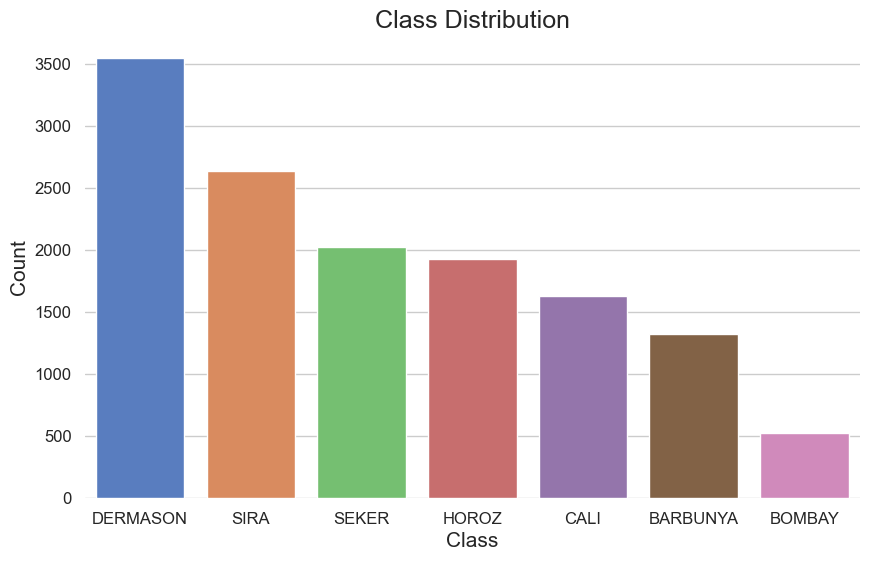

In [36]:
# Exploratory Data Analysis
# Set seaborn style
sns.set(style="whitegrid")

# Prepare the data
class_counts = df.Class.value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Class', y='Count', data=class_counts, palette='muted')

# Set plot title and labels
plt.title('Class Distribution', fontsize=18)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Count', fontsize=15)

# Customize plot appearance
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.despine(left=True, bottom=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot as a high-resolution image for publication
plt.savefig('../outputs/class_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


<Axes: >

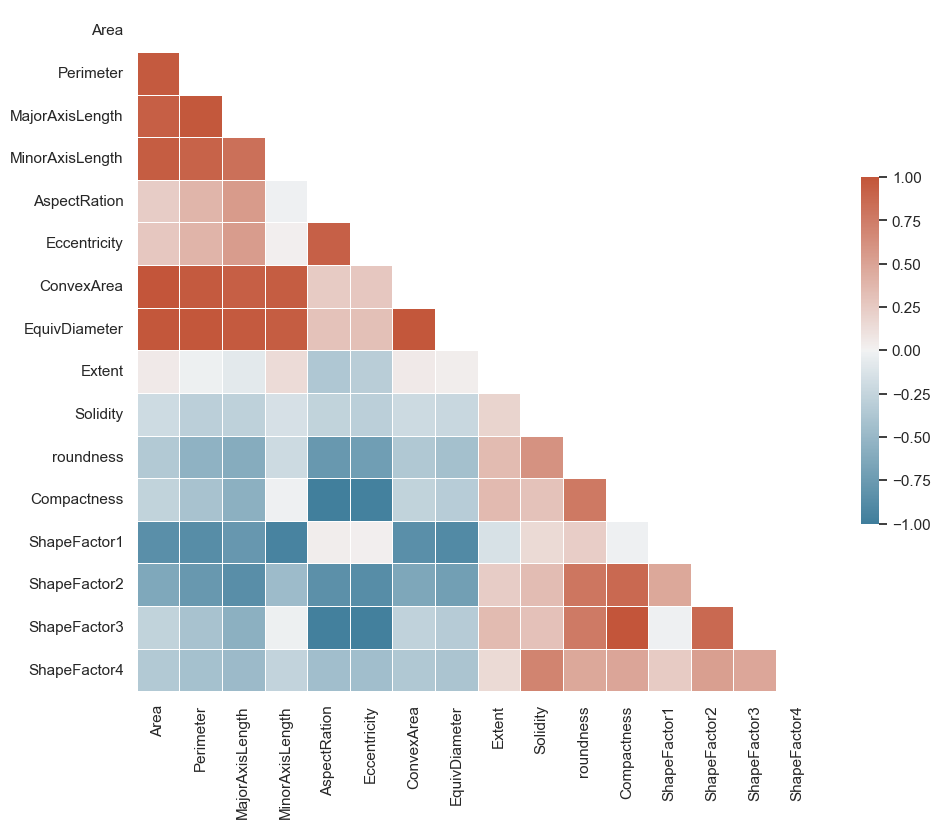

In [37]:
# Basic correlogram
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df[['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [38]:
def calculate_correlations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the correlations between features in a pandas DataFrame.
    
    Parameters:
    - df: Input pandas DataFrame
    
    Returns:
    - corr_matrix: pandas DataFrame containing correlation values between features
    """
    corr_matrix = df.corr()
    return corr_matrix

calculate_correlations(df=df[['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4']])

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
Area,1.000000,0.966722,0.931834,0.951602,0.241735,0.267481,0.999939,0.984968,0.054345,-0.196585,-0.357530,-0.268067,-0.847958,-0.639291,-0.272145,-0.355721
Perimeter,0.966722,1.000000,0.977338,0.913179,0.385276,0.391066,0.967689,0.991380,-0.021160,-0.303970,-0.547647,-0.406857,-0.864623,-0.767592,-0.408435,-0.429310
MajorAxisLength,0.931834,0.977338,1.000000,0.826052,0.550335,0.541972,0.932607,0.961733,-0.078062,-0.284302,-0.596358,-0.568377,-0.773609,-0.859238,-0.568185,-0.482527
MinorAxisLength,0.951602,0.913179,0.826052,1.000000,-0.009161,0.019574,0.951339,0.948539,0.145957,-0.155831,-0.210344,-0.015066,-0.947204,-0.471347,-0.019326,-0.263749
AspectRation,0.241735,0.385276,0.550335,-0.009161,1.000000,0.924293,0.243301,0.303647,-0.370184,-0.267754,-0.766979,-0.987687,0.024593,-0.837841,-0.978592,-0.449264
Eccentricity,0.267481,0.391066,0.541972,0.019574,0.924293,1.000000,0.269255,0.318667,-0.319362,-0.297592,-0.722272,-0.970313,0.019920,-0.860141,-0.981058,-0.449354
ConvexArea,0.999939,0.967689,0.932607,0.951339,0.243301,0.269255,1.000000,0.985226,0.052564,-0.206191,-0.362083,-0.269922,-0.847950,-0.640862,-0.274024,-0.362049
EquivDiameter,0.984968,0.991380,0.961733,0.948539,0.303647,0.318667,0.985226,1.000000,0.028383,-0.231648,-0.435945,-0.327650,-0.892741,-0.713069,-0.330389,-0.392512
Extent,0.054345,-0.021160,-0.078062,0.145957,-0.370184,-0.319362,0.052564,0.028383,1.000000,0.191389,0.344411,0.354212,-0.141616,0.237956,0.347624,0.148502
Solidity,-0.196585,-0.303970,-0.284302,-0.155831,-0.267754,-0.297592,-0.206191,-0.231648,0.191389,1.000000,0.607150,0.303766,0.153388,0.343559,0.307662,0.702163


In [39]:
# Principle Component Analysis to find the core comoponents in the data

class_labels = df[['Class']]
features = df[['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4']]

scalar = MinMaxScaler()
scaled_features = scalar.fit_transform(features)

# Target: 99% of the variance explained

pca = PCA(n_components= 0.99)
pca.fit(scaled_features)

df = pd.DataFrame(pca.transform(scaled_features))
df = pd.concat([df, class_labels],axis=1)

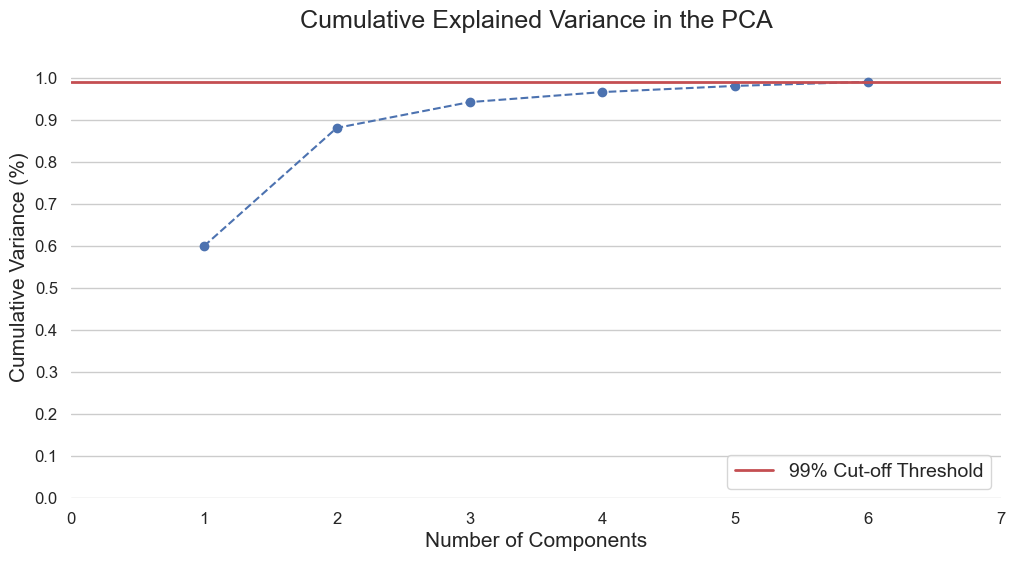

In [40]:
# Visualisation of the Number of Components for the Target
# Set seaborn style
sns.set(style="whitegrid")

# Prepare the data
xi = np.arange(1, 7, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(12, 6))
ax = plt.subplot()
plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b', label='Cumulative Variance')

# Set plot title and labels
plt.title('Cumulative Explained Variance in the PCA', fontsize=18)
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('Cumulative Variance (%)', fontsize=15)

# Customize plot appearance
red_line = plt.axhline(y=0.99, color='r', linestyle='-', linewidth=2, label='99% Cut-off Threshold')
plt.xticks(np.arange(0, 8, step=1), fontsize=12)
plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=12)

sns.despine(left=True, bottom=True)
ax.grid(axis='x')

# Create a legend in the right bottom corner
plt.legend(handles=[red_line], loc='lower right', fontsize=14)

# Save the plot as a high-resolution image for publication
plt.savefig('cumulative_variance_explained_with_legend.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



In [41]:
# Creating the Training Dataset, Validation Dataset and Testing Dataset

train_set, test_set = train_test_split(df,test_size=0.15)
test_set , valid_set = train_test_split(test_set,test_size=0.5)

train_set.reset_index(drop=True,inplace=True)
test_set.reset_index(drop=True,inplace=True)
valid_set.reset_index(drop=True,inplace=True)

# Dimension testing
print(f'Size Training Set: {train_set.shape}; Size Testing Set: {test_set.shape}; Size Validation Set: {valid_set.shape}')

Size Training Set: (11569, 7); Size Testing Set: (1021, 7); Size Validation Set: (1021, 7)


In [42]:
SPECIES_MAP = {
   'BARBUNYA':0,
   'BOMBAY':1,
   'CALI':2,
   'DERMASON':3,
   'HOROZ':4,
   'SEKER':5,
   'SIRA':6
}

def create_data_loader(X, Y, batch_size):
    dataset = TensorDataset(X, Y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

def feature_engineering(data: pd.DataFrame) -> Tuple[torch.tensor, torch.tensor]:
    features = torch.tensor(data[[0,1,2,3,4,5]].to_numpy(), dtype=torch.float)

    labels = torch.tensor(data.Class.map(SPECIES_MAP), dtype=torch.long)

    return features, labels



X_train, Y_train = feature_engineering(train_set)
X_test, Y_test = feature_engineering(test_set)
X_valid, Y_valid = feature_engineering(valid_set)

print(f'training data shapes: {X_train.shape}, {Y_train.shape}')
print(f'testing data shapes: {X_test.shape}, {Y_test.shape}')
print(f'validation data shapes: {X_valid.shape}, {Y_valid.shape}')

training data shapes: torch.Size([11569, 6]), torch.Size([11569])
testing data shapes: torch.Size([1021, 6]), torch.Size([1021])
validation data shapes: torch.Size([1021, 6]), torch.Size([1021])


In [43]:
class BeansClassifier(nn.Module):
    def __init__(self, input_dim=6,output_dim=7, hidden_dim=16):
        super(BeansClassifier,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, int(hidden_dim/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/2),output_dim)
        )
    
    def forward(self, x):
        return self.layers(x)
    
# Model Dim Testing
t = torch.randn(64,6)
model = BeansClassifier(input_dim=X_train.shape[1], output_dim=len(SPECIES_MAP))
print(f' Model output dimensions: {model(t).shape}') # returned values are basically random

 Model output dimensions: torch.Size([64, 7])


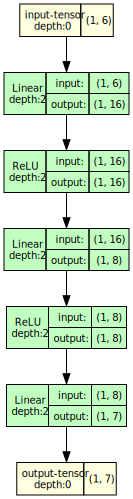

In [44]:
# Model Graph
model_graph = draw_graph(model, input_size=(1,6),expand_nested=False,roll=True,graph_dir='TB')
model_graph.visual_graph

In [45]:
# Hyperparameter
epochs = 50
batch_sizes = [16,32,64,256]
learning_rates = [0.000001,0.00001,0.00005,0.0001,0.01]
device = 'mps'

# Hyperparameter Early Stopping
patience = 5
num_epochs_without_improvement = 0

loss = []
mean_accuracies = []

In [26]:
# Start of the Grid Search training loop 
for batch_size in batch_sizes:

    # Creating dataloaders for train, test, and validation sets with the current batch size
    train_loader = create_data_loader(X_train, Y_train, batch_size=batch_size)
    test_loader = create_data_loader(X_test, Y_test, batch_size=batch_size)
    validation_loader = create_data_loader(X_valid, Y_valid, batch_size=batch_size)
    
    # Looping over different learning rates for the current batch size
    for learning_rate in learning_rates:
        t_loss = [] # List to keep track of training loss
        v_loss = [] # List to keep track of validation loss

        # Initialize the best validation loss to a high number
        best_validation_loss = float('inf')

        # Initialize the model and move it to the GPU if available
        model = BeansClassifier(input_dim=X_train.shape[1], output_dim=len(SPECIES_MAP))
        model = model.to(device)

        # Defining the Optimizer with the model parameters and learning rate
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

        # Defining the loss function (CrossEntropyLoss for multi-class classification)
        criterion = nn.CrossEntropyLoss()
        criterion = criterion.to(device)

        # Looping over each epoch
        for epoch in range(epochs):
            model.train() # Set the model to training mode
            epoch_loss = 0

            # Looping over batches in the train loader
            for batch_data, batch_label in train_loader: 
                # Move the data to the GPU if available
                batch_data = batch_data.to(device)
                batch_label = batch_label.to(device)

                # Forward pass: compute predicted outputs by passing inputs to the model
                preds = model(batch_data)
                # Compute loss
                training_loss = criterion(preds, batch_label)
                epoch_loss += training_loss.item()

                # Backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                training_loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()

            # Add the training loss for the current epoch to the list
            t_loss.append(epoch_loss)


            # Validation and Early Stopping
            # Switch to Evaluation 
            model.eval()
            valid_loss = 0

            # Remove gradient from the tensors
            with torch.no_grad():
                for batch_data, batch_label in validation_loader:
                    batch_data = batch_data.to(device)
                    batch_label = batch_label.to(device)

                    preds = model(batch_data)
                    validation_loss = criterion(preds, batch_label)
                    valid_loss += validation_loss.item()

            v_loss.append(valid_loss)
        
            current_validation_loss = valid_loss / len(validation_loader)

            # Check for improvement in validation loss
            if current_validation_loss < best_validation_loss:
                best_validation_loss = current_validation_loss
                num_epochs_without_improvement = 0

                # Save the best model weights
                best_model_weights = model.state_dict()
            else:
                num_epochs_without_improvement += 1

            # Early stopping check
            if num_epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch} for learning rate {learning_rate} and batch size {batch_size}")
                break

        # Load the best model weights
        model.load_state_dict(best_model_weights)
        classification_vector = []

        # Testing 
        model.eval()
        with torch.no_grad():
                test_loss = 0
                correct = 0

                X_test = X_test.to(device)
                Y_test = Y_test.to(device)

                preds = model(X_test)

                testing_loss = criterion(preds, Y_test)

                yhat = torch.argmax(preds, axis =1)
                classification_vector.append(yhat)
                correct += (yhat == Y_test).sum().item()

                test_accuarcy = metrics.accuracy_score(yhat.to("cpu"),Y_test.to("cpu"))        
        
        # Results
        print('\n---------------------------------------------------------------------------------\n')
        class_report = metrics.classification_report(Y_test.to('cpu'), yhat.to('cpu'))
        print(class_report)
        print(f'Accuracy: {test_accuarcy} - lr: {learning_rate} - bz: {batch_size}')

        predicted_labels = pd.DataFrame(yhat.to('cpu').numpy())
        predicted_labels.rename(columns={0:"predictions"},inplace=True)
        true_labels = pd.DataFrame(Y_test.to('cpu').numpy())
        true_labels.rename(columns={0:"ground truth"},inplace=True)

        output_df = pd.concat([predicted_labels, true_labels],axis=1)


Early stopping at epoch 40 for learning rate 1e-06 and batch size 16

---------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       111
           1       1.00      1.00      1.00        32
           2       0.97      0.94      0.95       111
           3       0.90      0.94      0.92       273
           4       0.96      0.96      0.96       138
           5       0.95      0.95      0.95       144
           6       0.88      0.86      0.87       212

    accuracy                           0.93      1021
   macro avg       0.94      0.94      0.94      1021
weighted avg       0.93      0.93      0.93      1021

Accuracy: 0.9275220372184133 - lr: 1e-06 - bz: 16
Early stopping at epoch 46 for learning rate 1e-05 and batch size 16

---------------------------------------------------------------------------------

              precision    recall  f1-score   s

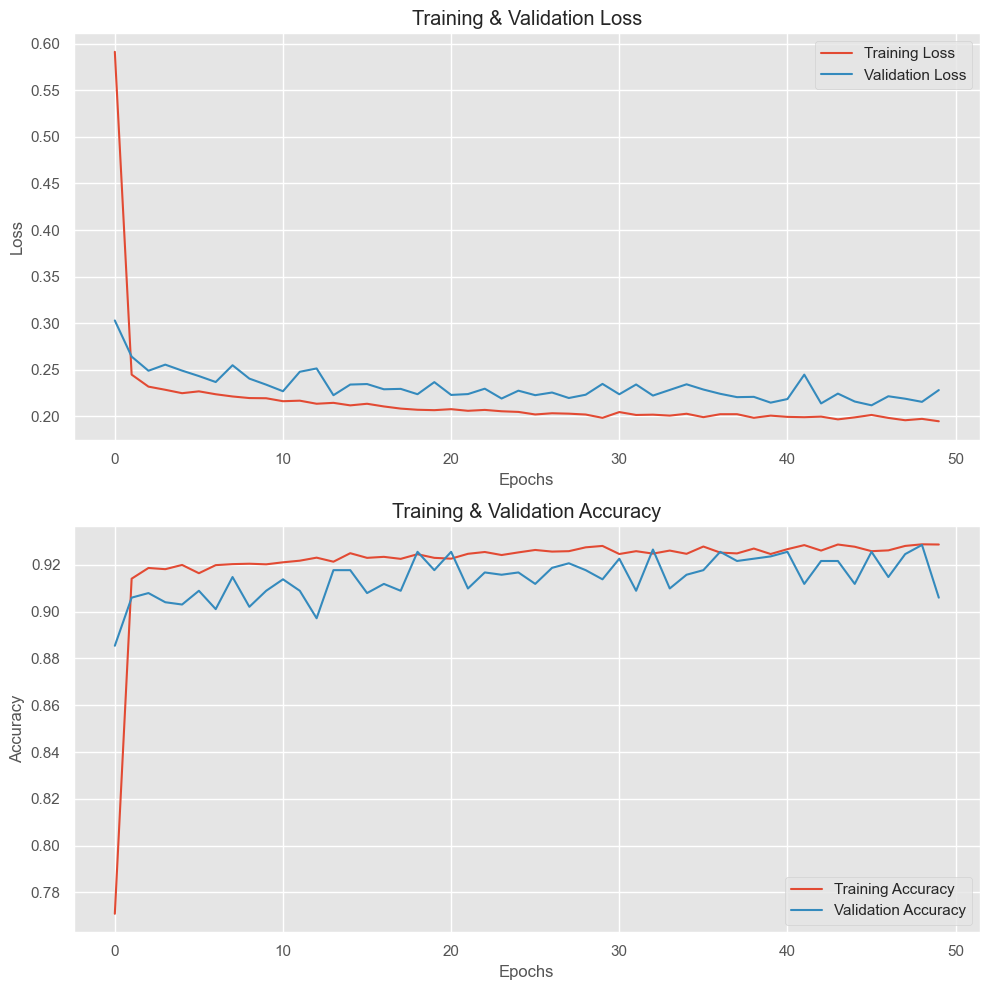

In [28]:
plt.style.use('ggplot')

# Hyperparameter
batch_size = 32
learning_rate = 0.01
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

# Dataloader
train_loader = create_data_loader(X_train, Y_train, batch_size=batch_size)
test_loader = create_data_loader(X_test, Y_test, batch_size=batch_size)
validation_loader = create_data_loader(X_valid, Y_valid, batch_size=batch_size)

model = BeansClassifier(input_dim=X_train.shape[1], output_dim=len(SPECIES_MAP))
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

# Criterion
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0

    for batch_data, batch_label in train_loader: 
        batch_data = batch_data.to(device)
        batch_label = batch_label.to(device)

        preds = model(batch_data)
        training_loss = criterion(preds, batch_label)
        epoch_loss += training_loss.item()

        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        correct_train += (preds.argmax(1) == batch_label).float().sum().item()

    epoch_loss /= len(train_loader) 

    train_accuracy = correct_train / len(train_loader.dataset)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(epoch_loss)

    # Validation
    model.eval()
    valid_loss = 0
    correct_valid = 0

    with torch.no_grad():
        for batch_data, batch_label in validation_loader:
            batch_data = batch_data.to(device)
            batch_label = batch_label.to(device)

            preds = model(batch_data)
            validation_loss = criterion(preds, batch_label)
            valid_loss += validation_loss.item()

            correct_valid += (preds.argmax(1) == batch_label).float().sum().item()

    valid_loss /= len(validation_loader)  # Average validation loss for each epoch
    valid_accuracy = correct_valid / len(validation_loader.dataset)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)


# Plotting
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

# Training and validation loss
ax1.plot(train_loss_list, label='Training Loss')
ax1.plot(valid_loss_list, label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Training and validation accuracy
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(valid_accuracy_list, label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


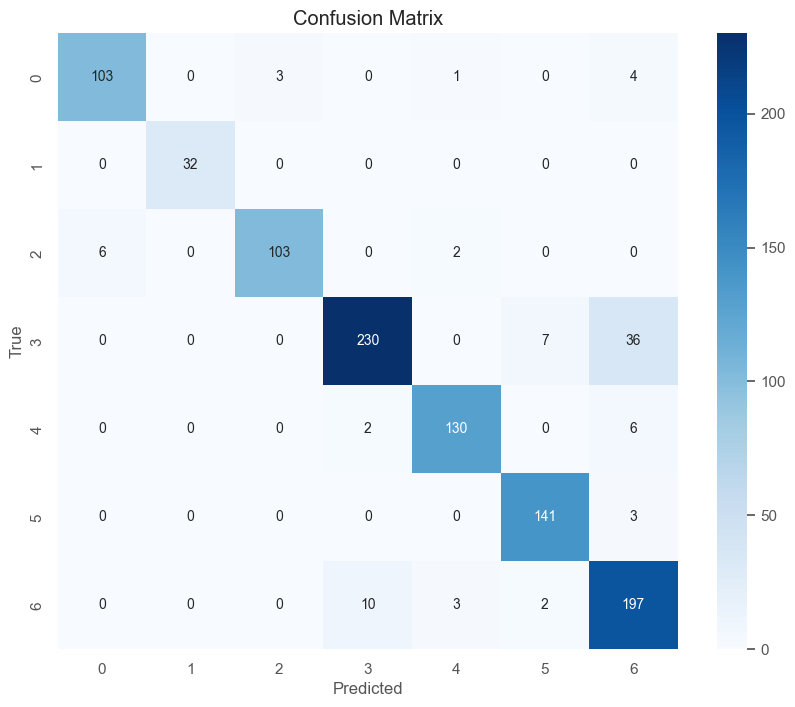

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       111
           1       1.00      1.00      1.00        32
           2       0.97      0.93      0.95       111
           3       0.95      0.84      0.89       273
           4       0.96      0.94      0.95       138
           5       0.94      0.98      0.96       144
           6       0.80      0.93      0.86       212

    accuracy                           0.92      1021
   macro avg       0.94      0.94      0.94      1021
weighted avg       0.92      0.92      0.92      1021

Accuracy: 0.9147894221351616 - lr: 0.01 - bz: 32


In [30]:
# Testing II / Metrics
model.eval()
classification_vector = []
with torch.no_grad():
    test_loss = 0
    correct = 0

    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    preds = model(X_test)

    testing_loss = criterion(preds, Y_test)

    yhat = torch.argmax(preds, axis =1)
    classification_vector.append(yhat)
    correct += (yhat == Y_test).sum().item()

    test_accuracy = metrics.accuracy_score(yhat.to("cpu"),Y_test.to("cpu"))


    
# Confusion matrix
confusion_mtx = confusion_matrix(Y_test.to('cpu'), yhat.to('cpu'))
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Metrics
class_report = metrics.classification_report(Y_test.to('cpu'), yhat.to('cpu'))
print(class_report)
print(f'Accuracy: {test_accuarcy} - lr: {learning_rate} - bz: {batch_size}')



# predicted_labels = pd.DataFrame(yhat.to('cpu').numpy())
predicted_labels.rename(columns={0:"predictions"},inplace=True)
true_labels = pd.DataFrame(Y_test.to('cpu').numpy())
true_labels.rename(columns={0:"ground truth"},inplace=True)

output_df = pd.concat([predicted_labels, true_labels],axis=1)
output_df.to_csv('/Users/luca/Desktop/ML/drybeansML/outputs/labels.csv', index=False) # write to CSV file
